In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras.models import Sequential
from keras.losses import Loss
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import scipy

In [2]:
# class KL_Divergence(Loss):
#     def call(self, y_true, y_pred

def neighbors_sum(lattice, i, j):
    '''
    Sums the spins of the lattice points at four neighbor sites to site (i,j).
        Takes into account the size of the lattice in 
        terms of number of rows (i) and columns (j),
        thus implementing periodic boundary conditions.
    '''
    latticesum = 0
    cell = 0
    if i > 0: #Up direction
        latticesum += lattice[i-1,j]
    else:
        latticesum += lattice[lattice.shape[0] - 1, j] #Periodic Boundary Condition
    if j < lattice.shape[1] - 1: #Right direction
        latticesum = lattice[i,j+1]
    else:
        latticesum = lattice[i,0] #Periodic Boundary Condition
    if i < lattice.shape[0] - 1: #Down direction
        latticesum = lattice[i+1,j]
    else:
        latticesum = lattice[0,j] #Periodic Boundary Condition
    if j > 0: #Left Direction
        latticesum += lattice[i,j-1]
    else:
        latticesum += lattice[i,lattice.shape[1] - 1] #Periodic Boundary Condition

    return latticesum

def local_energy(lattice, J, i, j):
    '''
    Calculates the energy of a specific point (i, j) on the lattice
    by adding up its interaction with each of its nearest neighbors
    according to E = -J * sum(s_ij*s_neighbor).
    '''
    #Every term of the sum has s_ij in it, so we can factor it out
    return -1 * J * lattice[i,j] * neighbors_sum(lattice, i, j)

def total_energy(lattice, J):
    '''
    Calculates the total energy of the lattice by counting all of the
    interactions while making sure that no interactions are double counted.
    Do so by calculating the local energy of every other lattice point
    '''
    energy_sum = 0
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if (i + j) % 2 == 0:
                energy_sum += local_energy(lattice, J, i, j)
    return energy_sum

def energy(N,M,nums):
    energies = []
    for n in nums:
        lattice = np.empty((N,M))
        for r in range(N):
            for c in range(M):
                if (n // 2**(M*r + c)) % 2:
                    lattice[r,c] = 1
                else:
                    lattice[r,c] = -1
        energies.append(total_energy(lattice, 1))
    return np.array(energies)

In [3]:
length = 5
width = 5
X = np.random.choice(2**(length*width), size=100000, replace=False)
#X = np.arange(2**9)
n_train = int(.9 * (X.shape[0]))
n_test = X.shape[0] - n_train
#energies = np.exp((-1)*energy(length,width,X)/(scipy.constants.k*300))
energies = -energy(length,width,X)
avg = np.median(energies)
y = energies > avg
y = 1*y
count = 0
for l in y:
    if l == 1:
        count+=1
print(count)
print((y.shape[0]))
X = np.array(X)[np.newaxis].T
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=n_test, random_state=1)

42058
100000


In [4]:
model = Sequential()

# Since our samples are only the X values (of either signal or background), the first layer just has one input dimension
model.add(Dense(1, input_dim=1, kernel_initializer='normal', activation='relu'))

# We then implement only one hidden layer with 8 neurons (you can experiment with changing this number)
n_neurons_hidden = 8
model.add(Dense(n_neurons_hidden, kernel_initializer='normal', activation='relu'))

# Finally we add one output layer
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Compile model
model.compile(loss='kl_divergence', optimizer='adam', metrics=['accuracy'])

# Print a summary of the model structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171 (684.00 B)

 Trainable params: 171 (684.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
history=model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=2048)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5219 - loss: 1.0959 - val_accuracy: 0.5819 - val_loss: 0.6861
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.5784 - loss: 0.6843 - val_accuracy: 0.5819 - val_loss: 0.6827
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.5793 - loss: 0.6834 - val_accuracy: 0.5819 - val_loss: 0.6824
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.5772 - loss: 0.6834 - val_accuracy: 0.5819 - val_loss: 0.6822
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.5778 - loss: 0.6833 - val_accuracy: 0.5819 - val_loss: 0.6821
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.5798 - loss: 0.6825 - val_accuracy: 0.5819 - val_loss: 0.6818
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.5800 - loss: 0.6823 - val_accuracy: 0.5819 - val_loss: 0.6815
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.5796 - loss: 0.6821 - val_accuracy: 0.58

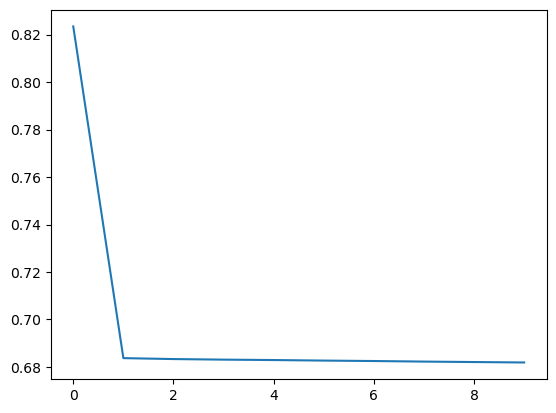

In [7]:
loss_history=history.history["loss"]
plt.plot(range(len(loss_history)),loss_history)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step


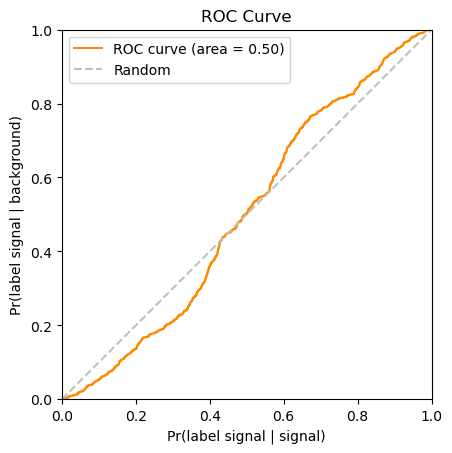

In [9]:
##### Here we make use of a function in scikit-learn to calculate the ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
                        
roc_auc = auc(fpr, tpr)

# Plot the ROC curve from the NN and overlay the ROC curve from the 1D classifier
plt.clf()
plt.axes().set_aspect('equal')
#plt.plot(ROCx,ROCy,label="LLR")
plt.plot(tpr,fpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],linestyle='--',color="#C0C0C0",label="Random")
plt.xlabel('Pr(label signal | signal)')
plt.ylabel('Pr(label signal | background)')
plt.title(r'ROC Curve')
plt.axis([0, 1, 0, 1])
plt.legend(loc='upper left')
plt.show()